In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

import joblib
import pandas as pd
import sys
import random
from tqdm import tqdm 
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
from sklearn import svm

from matplotlib import pyplot as plt
import numpy as np
import pickle
import os

from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score


In [15]:
class Digital_brain_dataset_transform(Dataset):
    def __init__(self, csv_file_path_train,max_distance_path):
        self.max_distance_path = max_distance_path
        
        self.data_frame = pd.read_csv(csv_file_path_train)
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx, mode='test'):
        pt_file = torch.load(self.data_frame.iloc[idx, 2])
        max_distance_dict = torch.load(self.max_distance_path)
#         print(self.max_distance_path)


        if mode == 'train':
            max_val = max_distance_dict[pt_file['img_path'].split('/')[-1].split('.jpg')[0].split('_')[0]]
            tfm = joblib.load('/storage/Ayantika/Diffusion_AE_hist_pathology/out1/'+pt_file['img_path'].split('/')[-1].split('.jpg')[0]+'.xfm')
            class_id = self.data_frame.iloc[idx, 0]
            image_ = pt_file['img']
            image = image_.clone()
            image = (image/torch.tensor(255)).to(torch.float32)
            sample = {'_train_image': image,'label':int(class_id),'idx':idx,\
                   'patch_info':pt_file['patch_info'],\
                  'img_path':pt_file['img_path'],\
                  'trans_matrix':pt_file['trans_matrix'], \
                   'centroid':pt_file['centroid'], \
                   'r':pt_file['transformation'][0],\
                  'theta':pt_file['transformation'][1],\
                  'add_angle':pt_file['add_angle'] ,\
                  'tfm_90':tfm,\
                  'max_val_slice':max_val}
            
            
        elif mode == 'test':
            class_id = self.data_frame.iloc[idx, 0]
            image_ = pt_file['img']
            image = image_.clone()
            image = (image/torch.tensor(255)).to(torch.float32)
            sample = {'_train_image': image,'label':int(class_id)}

        return sample
    
    
def save_clf(file_path,clf):
    # Save the trained classifier to a file
    with open(file_path, 'wb') as file:
        pickle.dump(clf, file)   
        
        
def load_clf(file_path):        
    # Load the saved classifier from the file
    with open(file_path, 'rb') as file:
        clf_loaded = pickle.load(file)
        
        
    return clf_loaded



In [16]:
def get_emb_from_models(model_name,model,dataloader_):
    df_list=[]
    count=0

    for i_batch, sampled_batch in enumerate(dataloader_):
            count = i_batch
            image_batch, label_batch = sampled_batch['_train_image'], sampled_batch['label']
            image_batch, label_batch = image_batch.cuda().float(), label_batch
            

            if model_name == 'MAE':
#             _,_,_,
                cond = model(image_batch)
                cond = cond.mean(dim=1)
    #             print(cond.shape)


            elif model_name == 'TransUnet':
                cond = model.transformer(image_batch)
                cond = cond[0]
                cond = cond.mean(dim=1)
    #             print(cond.shape)



            elif model_name == 'HIPT':
                cond = model(image_batch)
    #             print(cond.shape)



            elif model_name == 'DiffAE':
                cond = model.encode(image_batch)
    #             print(cond.shape)



            elif model_name == 'PosDiffAE':
                cond = model.encode(image_batch)
    #             print(cond.shape)
            ################
            batch_emb_list = [item.detach().cpu().numpy() for item in cond]

            # Create a list of DataFrames for embeddings
            dfs = [pd.DataFrame(data=emb) for emb in batch_emb_list]

            cond_data = pd.concat([*dfs],axis=1)

            cond_data_ = cond_data.T
            cond_data_[str(cond.shape[-1])] = label_batch
            df_final = cond_data_.T

            df_list.append(df_final)


    final_df_train = pd.concat(df_list, axis=1)
    train_data = final_df_train.transpose()
    y_train=train_data.iloc[:,-1]
    x_train=train_data.iloc[:,:cond.shape[-1]]
#     print("x_train.shape", x_train.shape)
#     print("y_train.shape", y_train.shape)
    
    
    return x_train,y_train

In [17]:
# !cp -r '/storage/Ayantika/Diffusion_AE_hist_pathology/PosDiffAE_model_call.py' '/storage/Ayantika/Diffusion_AE_hist_pathology/Final_PosDiffAE_histopath/PosDiffAE_/PoDiffAE/'

processing TransUnet


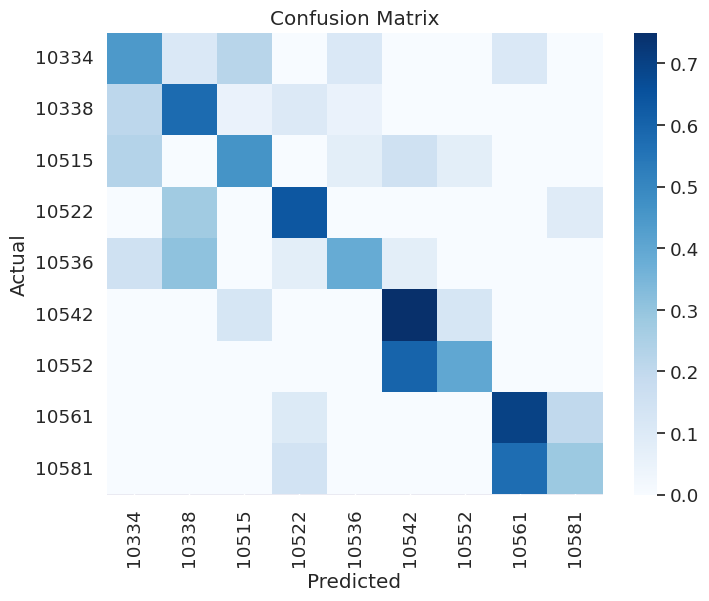

TransUnet
accuracy (%) 52.0
processing MAE


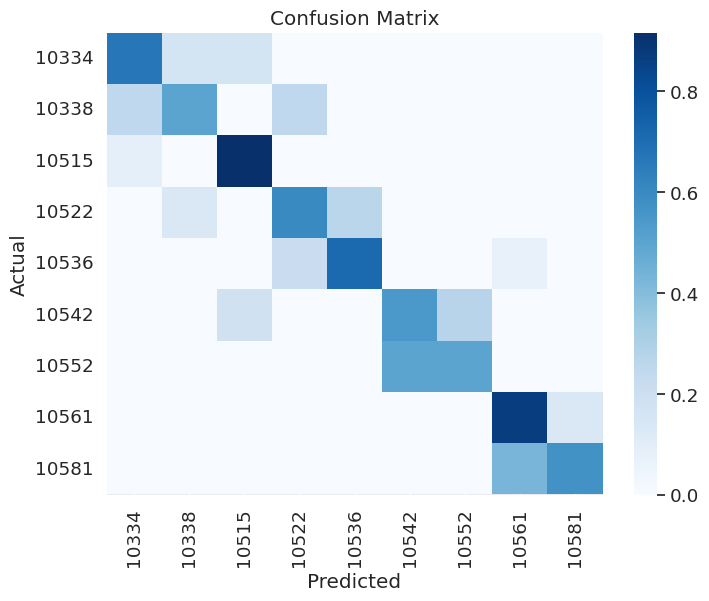

MAE
accuracy (%) 68.0
processing HIPT
Take key teacher in provided checkpoint dict
Pretrained weights found at ./HIPT/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


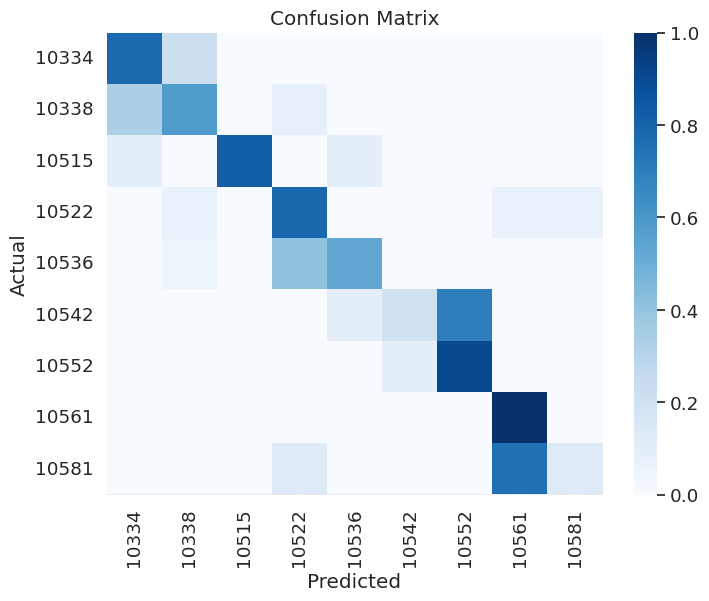

HIPT
accuracy (%) 64.0
processing DiffAE


Seed set to 0


Model params: 125.86 M


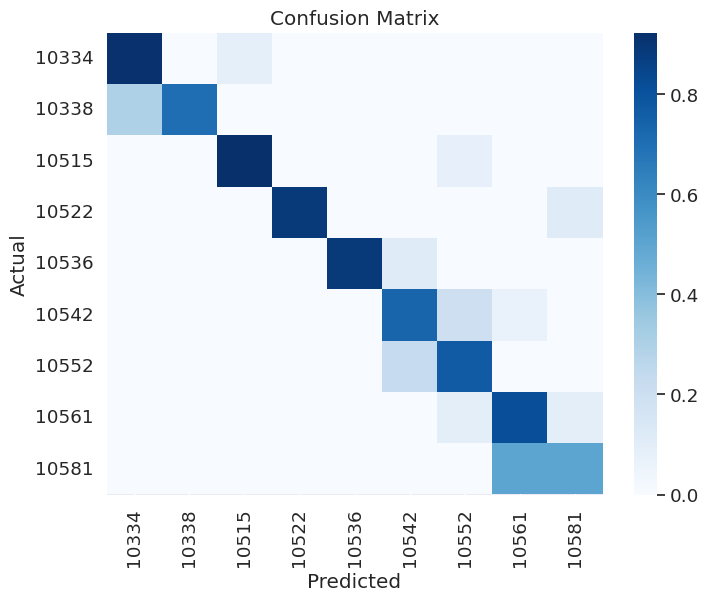

DiffAE
accuracy (%) 80.0
processing PosDiffAE


Seed set to 0


Model params: 125.86 M


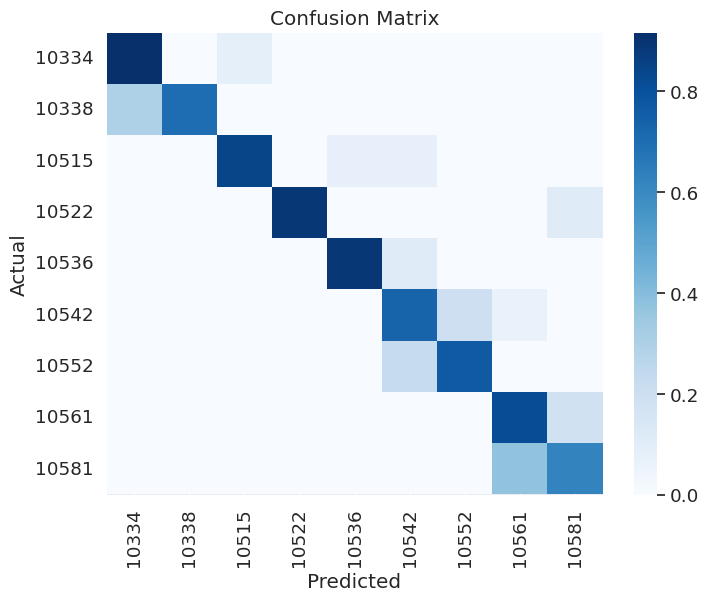

PosDiffAE
accuracy (%) 80.0


In [18]:
root_path = '/storage/Ayantika/analyse_1/brainspan_21_pcw/3'
train_r_theta_csv = root_path + '/train_with_r_theta.csv'
test_r_theta_csv = root_path +'/test_with_r_theta.csv'


batch_size_train = 5
batch_size_test = 5

csv_file_path_train= train_r_theta_csv
train_dataset = Digital_brain_dataset_transform(csv_file_path_train,max_distance_path_train)
train_dataloader = DataLoader(train_dataset,shuffle=False,batch_size=batch_size_train)

csv_file_path_test= test_r_theta_csv
test_dataset = Digital_brain_dataset_transform(csv_file_path_test,max_distance_path_test)
test_dataloader = DataLoader(test_dataset,shuffle=False,batch_size=batch_size_test)

# len(train_dataloader)
# for i,batch in enumerate(train_dataloader):
#     print(batch.keys())
#     print(batch['_train_image'].shape)
#     break
model_names = ['TransUnet', 'MAE','HIPT','DiffAE','PosDiffAE' ]
# 'DiffAE'
# 'HIPT'
# 'TransUnet'
# 'MAE'
for model_name in model_names:
    print("processing",model_name)
    
    if model_name == 'MAE':
        ####
        sys.path.insert(0,'./MAE')
        import MAE_model_call as MAE
        model,cond = MAE.model_call()

    elif model_name == 'TransUnet':
        ####
        sys.path.insert(0,'./TransUNet')
        import TransUnet_model_call as Tmc
        model_TransUnet = Tmc.vit_model_call()
        model, cond = model_TransUnet.model_call()

    elif model_name == 'HIPT':
        ####
        sys.path.insert(0,'./HIPT')
        from hipt_model_utils import get_vit256, get_vit4k, eval_transforms
        pretrained_weights256 = './HIPT/checkpoint.pth'
        model_HIPT = get_vit256(pretrained_weights=pretrained_weights256)
        model =  model_HIPT
    elif model_name == 'DiffAE':
        #####
        sys.path.insert(0,'./DiffAE/')
        import DiffAE_model_call as Dmc
        model_DiffAE = Dmc.DiffAE_model_call()
        model, cond = model_DiffAE.model_call()

    elif model_name == 'PosDiffAE':
        ####
        sys.path.insert(0,'./PosDiffAE/')
        import PosDiffAE_model_call as Pmc
        model_PosDiffAE = Pmc.PosDiffAE_model_call()
        model, cond = model_PosDiffAE.model_call()

    ####################################################
    if not os.path.exists(os.path.abspath('./')+'/Classifier_weights/'):
        os.mkdir(os.path.abspath('./')+'/Classifier_weights/')
    
    if not os.path.exists(os.path.abspath('./')+'/Classifier_weights/'+model_name):
        os.mkdir(os.path.abspath('./')+'/Classifier_weights/'+model_name)
        
    if not os.path.exists('./Classifier_weights/'+model_name+'/clf.pkl'):
        x_train,y_train = get_emb_from_models(model_name=model_name,model=model,dataloader_=train_dataloader)
        clf = svm.SVC(kernel='linear',C=1)
        clf.fit(x_train, y_train)
        save_clf('./Classifier_weights/'+model_name+'/clf.pkl',clf)
        
        
    clf = load_clf('./Classifier_weights/'+model_name+'/clf.pkl')


    # # Generate 1000 random indices
    accuracy_scores = []
#     for _ in range(0,1):
    _dataloader = test_dataloader
    random_indices = random.sample(range(len(_dataloader.dataset)), 100)

    # Create a subset dataloader using the randomly sampled indices
    subset_dataloader = DataLoader(dataset=_dataloader.dataset, 
                                    batch_size=_dataloader.batch_size,
                                    sampler=SubsetRandomSampler(random_indices))
    x_test,y_test = get_emb_from_models(model_name=model_name,model=model,dataloader_=subset_dataloader)

    y_pred=clf.predict(x_test)
    accuracy_scores.append(accuracy_score(y_test,y_pred))

    labels =np.unique(y_test).astype('int')
#         print(labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale for better visualization

    # Use seaborn heatmap for colored confusion matrix
    sns.heatmap(cm_normalized, annot=False, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


    print(model_name)

    print("accuracy (%)",accuracy_scores[0]*100)



